NLP Coursework Part - B

Student names and k-numbers:

1. Adharsh Vaiapuri (K2453494)
2. Avez Kazi (K2501085)

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import os


from datasets import load_dataset
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer
from IPython.display import display, HTML

os.environ["WANDB_DISABLED"] = "true"


**Task 1: Download the dataset and understand the structure and the three sentiment labels**

Used the "Financial Phrasebank" dataset and analyze the structure, label distribution,
and sample content. The labels are:
- 0 → positive
- 1 → neutral
- 2 → negative

In [39]:
from datasets import load_dataset
import pandas as pd

# Force download and load dataset into memory, disable local caching
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree", keep_in_memory=True)

# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(dataset["train"])

# Rename and map label values
df.columns = ["sentence", "label"]
label_map = {0: "negative", 1: "neutral", 2: "positive"}
df["label_name"] = df["label"].map(label_map)

# Display dataset summary
print("Sample data:")
print(df.head())

print("\nLabel distribution:")
print(df["label_name"].value_counts())

Sample data:
                                            sentence  label label_name
0  According to Gran , the company has no plans t...      1    neutral
1  For the last quarter of 2010 , Componenta 's n...      2   positive
2  In the third quarter of 2010 , net sales incre...      2   positive
3  Operating profit rose to EUR 13.1 mn from EUR ...      2   positive
4  Operating profit totalled EUR 21.1 mn , up fro...      2   positive

Label distribution:
label_name
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


**Exploratory Data Analysis**

1. Countplot for label distribution
2. Pie chart for label distribution
3. Word cloud for all sentences
4. Sentence length distribution

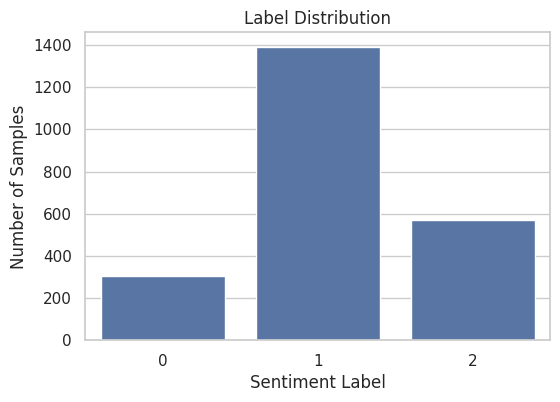

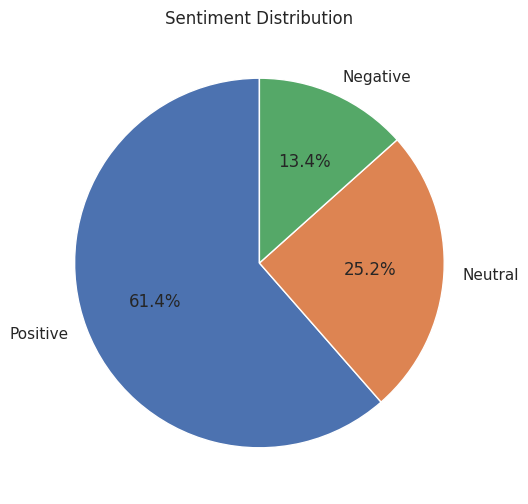

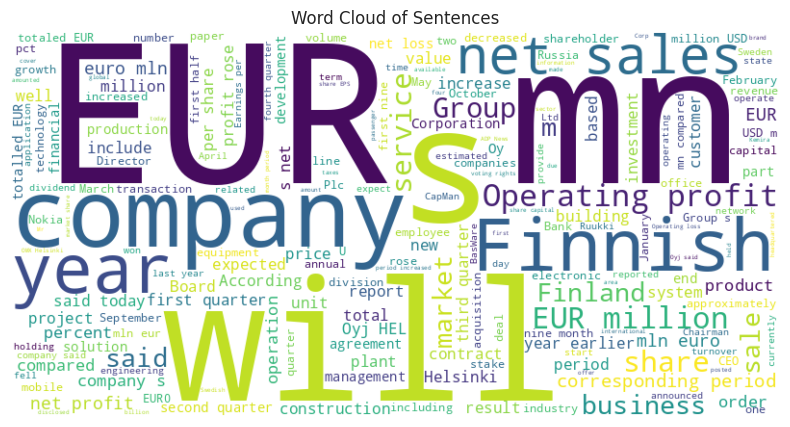

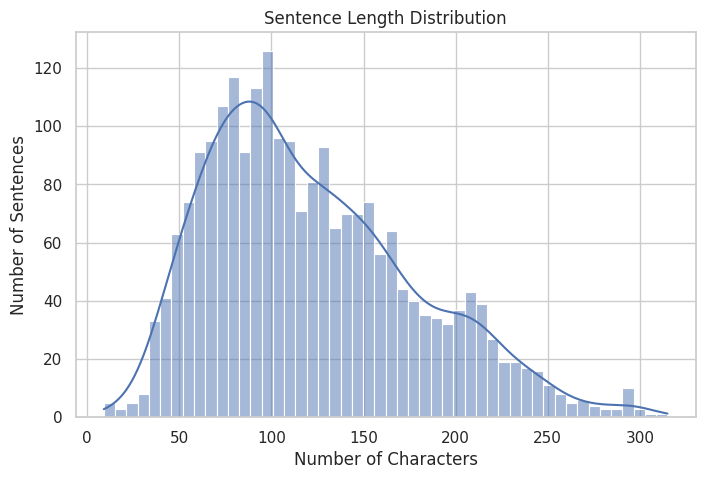

In [40]:
def sentiment_analysis_pipeline(df):
    # Set seaborn style
    sns.set(style="whitegrid")

    # 1. Countplot for label distribution
    plt.figure(figsize=(6,4))
    sns.countplot(x='label', data=df)
    plt.title('Label Distribution')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Number of Samples')
    plt.show()

    # 2. Pie chart for label distribution
    plt.figure(figsize=(6,6))
    df['label'].value_counts().plot.pie(
        autopct='%1.1f%%',
        labels=["Positive", "Neutral", "Negative"],
        startangle=90
    )
    plt.title('Sentiment Distribution')
    plt.ylabel('')
    plt.show()

    # 3. Word cloud for all sentences
    text = " ".join(sentence for sentence in df['sentence'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Sentences')
    plt.show()

    # 4. Sentence length distribution
    df['length'] = df['sentence'].apply(len)

    plt.figure(figsize=(8,5))
    sns.histplot(df['length'], bins=50, kde=True)
    plt.title('Sentence Length Distribution')
    plt.xlabel('Number of Characters')
    plt.ylabel('Number of Sentences')
    plt.show()

sentiment_analysis_pipeline(df)

**Visualise a subset of text examples along with their corresponding positive, negative, or
neutral labels to understand the classification task.**

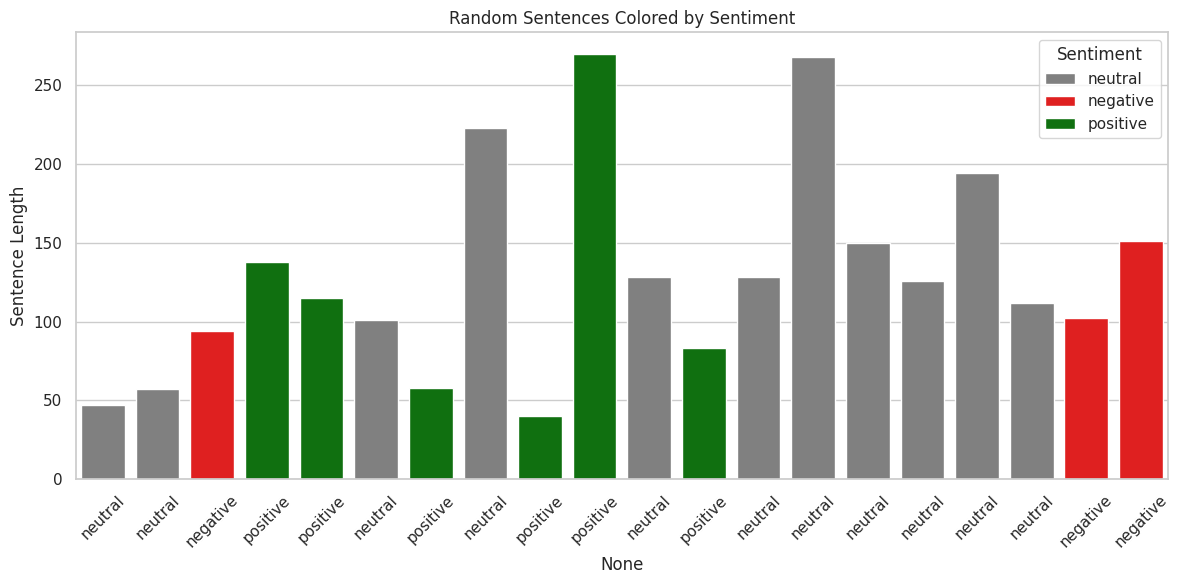

In [41]:
# Sample a subset
sample_df = df.sample(20).reset_index(drop=True)

# Map numeric labels to sentiment names
label_map = {0: "negative", 1: "neutral", 2: "positive"}
sample_df['label_name'] = sample_df['label'].map(label_map)

# Plot
plt.figure(figsize=(12, 6))

sns.barplot(
    data=sample_df,
    x=sample_df.index,
    y=sample_df["sentence"].str.len(),
    hue="label_name",  # Use mapped sentiment labels
    palette={"positive": "green", "neutral": "gray", "negative": "red"},
    dodge=False
)

plt.xticks(ticks=sample_df.index, labels=sample_df["label_name"], rotation=45)
plt.ylabel("Sentence Length")
plt.title("Random Sentences Colored by Sentiment")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

**Split the dataset into training, validation, and testing sets. Try to maintain class
proportions across the splits.**

In [42]:
# Check the columns in your dataframe
print("Columns in the dataframe:", df.columns)

# Ensure you're using the correct label column name (e.g., 'label', 'category', etc.)
# Update the following code with the correct column name based on your output

# First split: 80% train, 20% temp (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],   # Replace with the correct column name if it's not 'label'
    random_state=42
)

# Second split: 50% of temp = 10% of total for validation, 10% for test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],  # Replace with the correct column name here as well
    random_state=42
)

# Confirm sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Columns in the dataframe: Index(['sentence', 'label', 'label_name', 'length'], dtype='object')
Train size: 1811
Validation size: 226
Test size: 227


**Format the text data for pre-trained models using a suitable tokeniser. Ensure consistent
input lengths through padding or truncation if needed. Encode the "positive", "negative",
and "neutral" labels numerically.**

In [43]:
from transformers import AutoTokenizer

# Map numeric labels to names (for clarity)
label_map = {0: "negative", 1: "neutral", 2: "positive"}
df["label_name"] = df["label"].map(label_map)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize with padding and truncation
tokenized = tokenizer(
    list(df["sentence"]),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Map label names back to numeric form (if needed)
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label_id"] = df["label_name"].map(label_map)

# Optional: Show a tokenized sample
print("Tokenized input example:")
print(tokenized["input_ids"][0])

Tokenized input example:
tensor([  101,  2429,  2000, 12604,  1010,  1996,  2194,  2038,  2053,  3488,
         2000,  2693,  2035,  2537,  2000,  3607,  1010,  2348,  2008,  2003,
         2073,  1996,  2194,  2003,  3652,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,    

**Fine-tune at least two diTerent pre-trained Transformer models for the 3-class text
classification task.**

**bert-base-uncased**

In [44]:
# Load the tokenizer for the model you plan to use
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define a custom Dataset class to handle the tokenization and labels
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the sentence and label
        sentence = self.data.iloc[idx]["sentence"]
        label = self.data.iloc[idx]["label"]

        # Tokenize the sentence
        encoding = self.tokenizer(
            sentence,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Print the shape of the tokenized input (debugging step)
        print(f"Tokenized input: {encoding}")

        # Add label to the encoding
        encoding["labels"] = torch.tensor(label, dtype=torch.long)

        # Ensure there are no nested dimensions for tensors (should be 1D for each)
        encoding = {key: value.squeeze(0) for key, value in encoding.items()}  # Remove extra dimension

        return encoding

# Create datasets for train, validation, and test
train_dataset = CustomDataset(train_df, tokenizer, max_length=128)
val_dataset = CustomDataset(val_df, tokenizer, max_length=128)
test_dataset = CustomDataset(test_df, tokenizer, max_length=128)

# Load the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # number of training epochs
    per_device_train_batch_size=4,   # batch size for training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Use the custom dataset for training
    eval_dataset=val_dataset      # Use the custom dataset for validation
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)
print(results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Tokenized input: {'input_ids': tensor([[  101,  4748,  2361,  2638,  9333,  1011, 11703,  2603,  1010,  2268,
          1011,  5046,  3361,  2578,  2177,  8622,  9299,  1015, 24665, 29547,
          2078,  2004,  9808,  2140,  1024, 24829, 16523,  2361,  2056,  2049,
          2604,  1997,  5501,  2805,  2651, 15723,  2571,  5292, 15916,  6605,
          2472,  1997,  2049,  4447,  3074,  7506,  8622,  9299,  1015, 24665,
         29547,  2078, 10346,  6962,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0

Step,Training Loss
10,1.078400
20,1.036900
30,1.093300
40,1.020100
50,0.998200
60,0.915900
70,0.928000
80,0.897500
90,0.803500
100,0.768200


Streaming output truncated to the last 5000 lines.
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Tokenized input: {'input_ids': tensor([[ 101, 1996, 2194, 5748, 2049, 2449, 2083, 2048, 3189, 3085, 9214, 1010,
         2164, 8169, 1998, 5211, 2578, 1010, 1998, 2512, 1011, 2166, 5427, 1012,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [45]:
# Get raw predictions
predictions_output = trainer.predict(test_dataset)

# Extract logits and predicted class labels
logits = predictions_output.predictions
y_pred = logits.argmax(axis=1)
y_true = [example['labels'] for example in test_dataset]

Tokenized input: {'input_ids': tensor([[  101,  2053,  3361,  4751,  1997,  1996, 10813,  2020, 21362,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0

Streaming output truncated to the last 5000 lines.
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Tokenized input: {'input_ids': tensor([[  101,  2053,  3361,  4751,  1997,  1996, 10813,  2020, 21362,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0

Tokenized input: {'input_ids': tensor([[ 101, 1996, 2194, 5748, 2049, 2449, 2083, 2048, 3189, 3085, 9214, 1010,
         2164, 8169, 1998, 5211, 2578, 1010, 1998, 2512, 1011, 2166, 5427, 1012,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


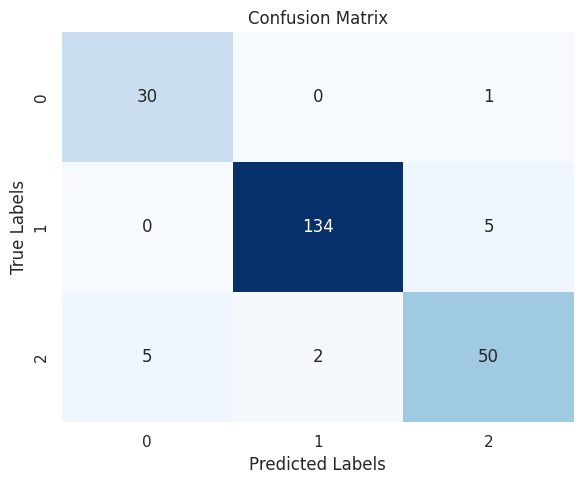

In [46]:
# Get predictions from the model
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Print metrics only
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**Format the text data for pre-trained models using a suitable tokeniser. Ensure consistent
input lengths through padding or truncation if needed. Encode the "positive", "negative",
and "neutral" labels numerically**

In [47]:
from transformers import AutoTokenizer

# Map numeric labels to names
label_map = {0: "negative", 1: "neutral", 2: "positive"}
df["label_name"] = df["label"].map(label_map)

# Load tokenizer for distilbert-base-uncased
tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize with padding and truncation
tokenized_distilbert = tokenizer_distilbert(
    list(df["sentence"]),
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Map label names back to numeric form (if needed)
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label_id_distilbert"] = df["label_name"].map(label_map)

# Show example
print("Tokenized input example (DistilBERT):")
print(tokenized_distilbert["input_ids"][0])

Tokenized input example (DistilBERT):
tensor([  101,  2429,  2000, 12604,  1010,  1996,  2194,  2038,  2053,  3488,
         2000,  2693,  2035,  2537,  2000,  3607,  1010,  2348,  2008,  2003,
         2073,  1996,  2194,  2003,  3652,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

**Evaluate the performance of your fine-tuned models on the test set using appropriate
multi-class classification metrics such as accuracy, precision, recall, F1-score, and a
confusion matrix.**

In [48]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]["sentence"]
        label = self.data.iloc[idx]["label"]

        encoding = self.tokenizer(
            sentence,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # DistilBERT does not use token_type_ids
        encoding.pop("token_type_ids", None)
        encoding["labels"] = torch.tensor(label, dtype=torch.long)
        encoding = {key: value.squeeze(0) for key, value in encoding.items()}
        return encoding

# Create datasets
train_dataset = CustomDataset(train_df, tokenizer, max_length=128)
val_dataset = CustomDataset(val_df, tokenizer, max_length=128)
test_dataset = CustomDataset(test_df, tokenizer, max_length=128)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results_distilbert",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_distilbert",
    logging_steps=10
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

# Evaluate on test set after training is completed
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,1.131800
20,1.143800
30,1.120300
40,1.101800
50,1.051400
60,1.007000
70,1.016600
80,0.928700
90,0.891300
100,0.743500


Test Results: {'eval_loss': 0.18702606856822968, 'eval_runtime': 0.9178, 'eval_samples_per_second': 247.342, 'eval_steps_per_second': 16.344, 'epoch': 3.0}


Classification Report:
              precision    recall  f1-score   support

           0     0.9333    0.9032    0.9180        31
           1     0.9857    0.9928    0.9892       139
           2     0.9474    0.9474    0.9474        57

    accuracy                         0.9692       227
   macro avg     0.9555    0.9478    0.9515       227
weighted avg     0.9689    0.9692    0.9690       227



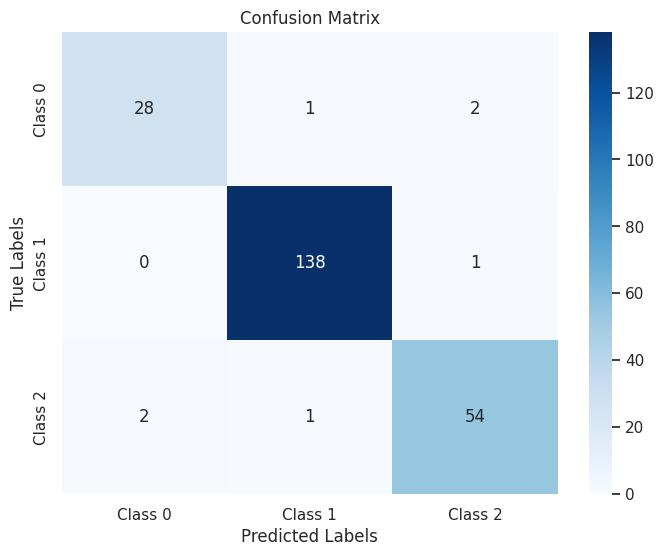

In [49]:
# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)  # Get the predicted class indices
labels = predictions.label_ids  # True labels

# Classification Report
print("Classification Report:")
print(classification_report(labels, preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(labels, preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

**Compare the results of the diTerent pre-trained models.**

Model Performance Comparison:


,accuracy,precision,recall,f1,loss
bert-base-uncased,0.9736,0.9740,0.9736,0.9737,0.1813
distilbert-base-uncased,0.9604,0.9616,0.9604,0.9607,0.2196


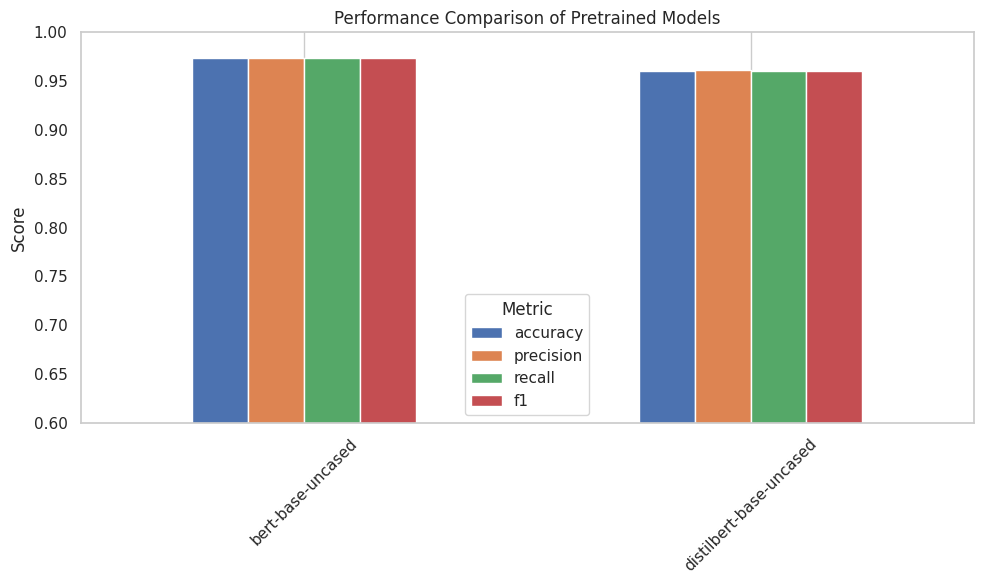

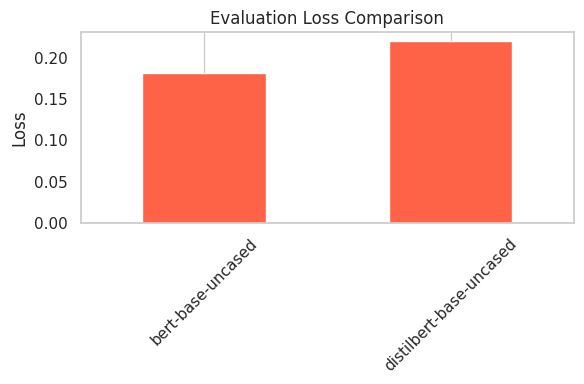

In [50]:
# Store evaluation metrics for each model
results_dict = {
    "bert-base-uncased": {
        "accuracy": 0.9736,
        "precision": 0.9740,
        "recall": 0.9736,
        "f1": 0.9737,
        "loss": 0.1813
    },
    "distilbert-base-uncased": {
        "accuracy": 0.9604,
        "precision": 0.9616,
        "recall": 0.9604,
        "f1": 0.9607,
        "loss": 0.2196
    }
}

# Create DataFrame for comparison
results_df = pd.DataFrame(results_dict).T.round(4)

# Display the DataFrame
print("Model Performance Comparison:")
display(results_df)

# Plot accuracy, precision, recall, and F1-score
metrics = ["accuracy", "precision", "recall", "f1"]
results_df[metrics].plot(kind='bar', figsize=(10, 6))
plt.title("Performance Comparison of Pretrained Models")
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot evaluation loss
results_df["loss"].plot(kind='bar', color='tomato', figsize=(6, 4))
plt.title("Evaluation Loss Comparison")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()